# Inteligent Systems
## HW 2
### Reza Jahani  /  810198377

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import preprocessing

# Question 2

## Data Preprocessing

In [ ]:
train = pd.read_csv('titanic-train.csv')
test = pd.read_csv('titanic-test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Embarked  889 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [ ]:
encoder = preprocessing.LabelEncoder()

def prepro(data, isTest):
    try:
        # data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
        data['Age'] = data['Age'].fillna(data['Age'].median())
        data['Fare'] = data['Fare'].fillna(data['Fare'].median())
        data['Embarked'] = data['Embarked'].fillna('S')
        data['Sex'] = encoder.fit_transform(data['Sex'])  
    except KeyError as e:
        print('Invalid preprocess')
        print(e)
    return data

In [ ]:
train = prepro(train, True)
train.head()

,Survived,Pclass,Embarked,Sex,Age,SibSp,Parch,Fare
0,0,3,S,1,22.0,1,0,7.2500
1,1,1,C,0,38.0,1,0,71.2833
2,1,3,S,0,26.0,0,0,7.9250
3,1,1,S,0,35.0,1,0,53.1000
4,0,3,S,1,35.0,0,0,8.0500


In [ ]:
test = prepro(test, False)
test = test.drop(['Cabin'], axis = 1)
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,Q
1,3,0,47.0,1,0,7.0000,S
2,2,1,62.0,0,0,9.6875,Q
3,3,1,27.0,0,0,8.6625,S
4,3,0,22.0,1,1,12.2875,S


In [ ]:
categorical_cols = [col for col in train.columns if
                   train[col].nunique() < 10 and
                   train[col].dtype == 'object'
                   ]
numerical_cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]

print(categorical_cols)
print(numerical_cols)

['Embarked']
['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']


In [ ]:
train = pd.get_dummies(train)
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,1
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,0,0,1
887,1,1,0,19.0,0,0,30.0000,0,0,1
888,0,3,0,28.0,1,2,23.4500,0,0,1
889,1,1,1,26.0,0,0,30.0000,1,0,0


## Part 1

### Dataset Split

In [ ]:
Y = train['Survived'].values
X = train.drop(['Survived'],axis = 1).values

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(X, Y, test_size=0.15)

### Decision Tree

In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, Y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self.grow_tree(X, Y)

    def grow_tree(self, X, Y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(Y))

        # Stopping Condition
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self.most_common_label(Y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # Figuring Best Split
        best_feature, best_thresh = self.best_split(X, Y, feat_idxs)

        # Generating Child Nodes
        left_idxs, right_idxs = self.split(X[:, best_feature], best_thresh)
        left = self.grow_tree(X[left_idxs, :], Y[left_idxs], depth+1)
        right = self.grow_tree(X[right_idxs, :], Y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                gain = self.information_gain(y, X_column, thr)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def information_gain(self, y, X_column, threshold):
        parent_entropy = self.entropy(y)
        left_idxs, right_idxs = self.split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self.entropy(y[left_idxs]), self.entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r
        information_gain = parent_entropy - child_entropy
        return information_gain

    def split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        entropy_ = - np.sum(ps * np.log2(ps))
        return entropy_

    def most_common_label(self, y):
        labels, labels_count = np.unique(y, return_counts=True)
        if len(labels) == 0:
            return np.random.randint(0,2)
        value = labels[np.argmax(labels_count)]
        return value

    def predict(self, X):
        return np.array([self.traverse_tree(x, self.root) for x in X])

    def traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self.traverse_tree(x, node.left)
        else:
            return self.traverse_tree(x, node.right)
        

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

In [ ]:
def confusion_matrix(y_val, y_pred):
    c = np.array([[0,0],
                  [0,0]])
    n = len(y_val)
    for i in range(n):
        temp = [y_val[i],y_pred[i]]
        if temp == [0,0]:
            c[0][0] = c[0][0] + 1
        if temp == [0,1]:
            c[0][1] = c[0][1] + 1
        if temp == [1,0]:
            c[1][0] = c[1][0] + 1
        if temp == [1,1]:
            c[1][1] = c[1][1] + 1
    return c

### Training the Model

In [ ]:
max_depth = [1,2,3,4,5,6,7]
accuracy_values = []
confusion_matrices = []
for depth in max_depth:
    clf = DecisionTree(max_depth=depth)
    clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_val)

    acc = np.round(accuracy(y_val, y_pred),2) * 100
    accuracy_values.append(acc)

    confusion_matrices.append(confusion_matrix(y_val,y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in multiply


### Evaluation of the Model

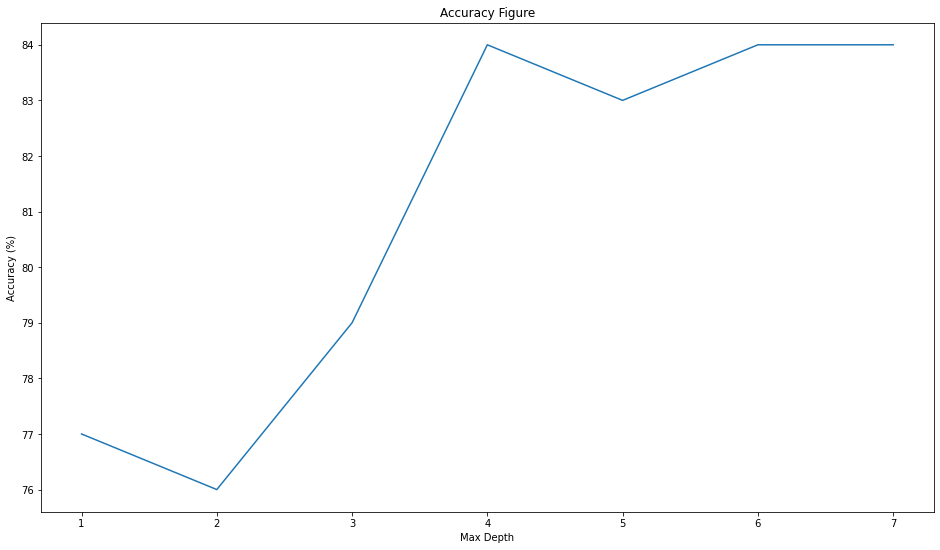

-----------------------
Max Depth of the Tree = 1
Accuracy = 77.0%
****
Confusion Matrix
[[60 11]
 [20 43]]
-----------------------
Max Depth of the Tree = 2
Accuracy = 76.0%
****
Confusion Matrix
[[70  1]
 [31 32]]
-----------------------
Max Depth of the Tree = 3
Accuracy = 79.0%
****
Confusion Matrix
[[61 10]
 [18 45]]
-----------------------
Max Depth of the Tree = 4
Accuracy = 84.0%
****
Confusion Matrix
[[67  4]
 [18 45]]
-----------------------
Max Depth of the Tree = 5
Accuracy = 83.0%
****
Confusion Matrix
[[64  7]
 [16 47]]
-----------------------
Max Depth of the Tree = 6
Accuracy = 84.0%
****
Confusion Matrix
[[66  5]
 [16 47]]
-----------------------
Max Depth of the Tree = 7
Accuracy = 84.0%
****
Confusion Matrix
[[67  4]
 [18 45]]
-----------------------


In [ ]:
plt.figure(figsize=[16,9])
plt.plot(max_depth,accuracy_values)
plt.title('Accuracy Figure')
plt.ylabel('Accuracy (%)')
plt.xlabel('Max Depth')
plt.show()
print("-----------------------")

for i in range(len(max_depth)):
    print(f'Max Depth of the Tree = {max_depth[i]}')
    print(f"Accuracy = {accuracy_values[i]}%")
    print("****")
    print("Confusion Matrix")
    print(confusion_matrices[i])
    print("-----------------------")

As it can be observed above, in the overal prespective the higher the max depth gets, higher accuracy will be obtained. Because more features are involved in predicting the label. Also the confusion matrix is shown in each step. As already stated in the lecture notes, horizental axis indicates the predicted labels where vertical axis indicates the true labes.

## Part 2

When it comes to training of the decision tree, based on the derived model, some features are chosen to be employed for prediction of label based on max depth and this fact limits the performance of the tree in prediction of label because some of the feature may be held unused when they can seem useful in labels prediction. 
Employing Bagging or Random Forest which in fact is using a number of decision trees which are trained with different configurations and then taking a majority vote among all the results can lead to better accuracy. 
Let us have 3 decision trees that each of them use different features to predict the label and the final result of the prediction from each tree will be [1,1,0]. In this case the final prediction will be “1” which has occurred twice among the trees. Obviously this action increases the accuracy since more features and more trees are involved in label prediction.


## Part 3

Using Random Forest for Model

Number of trees = 3

In [ ]:
tree = [None] * 3

In [ ]:
depth = [3,4,6]
for i in range(3):
    x_tr, x_val, y_tr, y_val = train_test_split(X, Y, test_size=0.15, random_state=1234)
    tree[i] = DecisionTree(max_depth = depth[i])
    tree[i].fit(x_tr,y_tr)
x_test = x_val
y_test = y_val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in multiply


In [ ]:
y_pred = np.zeros((len(y_test),3))
for i in range(3):
    y_pred[:,i] = tree[i].predict(x_test)

In [ ]:
y_predicted = np.zeros(len(y_test))
for i in range(len(y_test)):
    sample = y_pred[i]
    unique_vals, counts = np.unique(sample, return_counts = True)
    y_predicted[i] = unique_vals[np.argmax(counts)]

In [ ]:
accuracy_RF1 = accuracy(y_test, y_predicted)
CM_RF1 = confusion_matrix(y_test, y_predicted)
print("Random Forest with 3 Decision Trees")
print(f"Accuracy={np.round(accuracy_RF1,4)*100}%")
print("**Confusion Matrix**")
print(CM_RF1)

Random Forest with 3 Decision Trees
Accuracy=82.09%
**Confusion Matrix**
[[73  6]
 [18 37]]


Number of Trees = 6

In [ ]:
tree = [None] * 6

depth = [3,4,6,3,5,4]
for i in range(6):
    x_tr, x_val, y_tr, y_val = train_test_split(X, Y, test_size=0.15, random_state=1234)
    tree[i] = DecisionTree(max_depth = depth[i])
    tree[i].fit(x_tr,y_tr)
x_test = x_val
y_test = y_val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in multiply


In [ ]:
y_pred = np.zeros((len(y_test),6))
for i in range(6):
    y_pred[:,i] = tree[i].predict(x_test)

y_predicted = np.zeros(len(y_test))
for i in range(len(y_test)):
    sample = y_pred[i]
    unique_vals, counts = np.unique(sample, return_counts = True)
    y_predicted[i] = unique_vals[np.argmax(counts)]

accuracy_RF2 = accuracy(y_test, y_predicted)
CM_RF2 = confusion_matrix(y_test, y_predicted)
print("Random Forest with 6 Decision Trees")
print(f"Accuracy={np.round(accuracy_RF2,4)*100}%")
print("**Confusion Matrix**")
print(CM_RF2)

Random Forest with 6 Decision Trees
Accuracy=81.34%
**Confusion Matrix**
[[74  5]
 [20 35]]


Number of Trees = 15

In [ ]:
tree = [None] * 15

depth = [3,4,6,3,5,4,3,4,6,3,5,4,3,4,6]
for i in range(15):
    x_tr, x_val, y_tr, y_val = train_test_split(X, Y, test_size=0.15, random_state=1234)
    tree[i] = DecisionTree(max_depth = depth[i])
    tree[i].fit(x_tr,y_tr)
x_test = x_val
y_test = y_val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in multiply


In [ ]:
y_pred = np.zeros((len(y_test),15))
for i in range(15):
    y_pred[:,i] = tree[i].predict(x_test)

y_predicted = np.zeros(len(y_test))
for i in range(len(y_test)):
    sample = y_pred[i]
    unique_vals, counts = np.unique(sample, return_counts = True)
    y_predicted[i] = unique_vals[np.argmax(counts)]

accuracy_RF3 = accuracy(y_test, y_predicted)
CM_RF3 = confusion_matrix(y_test, y_predicted)
print("Random Forest with 15 Decision Trees")
print(f"Accuracy={np.round(accuracy_RF3,4)*100}%")
print("**Confusion Matrix**")
print(CM_RF3)

Random Forest with 15 Decision Trees
Accuracy=82.84%
**Confusion Matrix**
[[73  6]
 [17 38]]


As observed above as the number of trees in Random Forest, the accuracy and overal performance of the model increases.

# Question 3

## KNN

### Part 1

Loading & Partitioning the Dataset

In [ ]:
def data_splitter(xdata,labels,split):
    n = xdata.shape[0]
    data_index = np.arange(0,n)
    np.random.shuffle(data_index)
    train_index = data_index[0:int((1-split)*n)]
    test_index = data_index[int((1-split*n)):]
    x_train = xdata[train_index]
    x_test = xdata[test_index]
    y_train = labels[train_index]
    y_test = labels[test_index]
    return x_train,x_test,y_train,y_test

In [ ]:
from sklearn.datasets import load_wine
data = load_wine()

In [ ]:
X = data.data
Y = data.target

In [ ]:
x_train, x_test, y_train, y_test = data_splitter(X,Y,0.2)

The KNN Model

In [ ]:
def distance(w,X):
    # w: test data      X: Saved Dataset
    L1 = X-w
    L2 = L1 ** 2
    dist_vector = np.sqrt(np.sum(L2, axis = 1))
    return dist_vector

In [ ]:
def KNN_Model(x, X, Y, k):
    n = x.shape[0]
    y = np.zeros(n)
    for i in range(n):
        t = x[i]
        dist = distance(t,X)
        neighbours_index = np.argsort(dist)[:k]
        neighbours_label = Y[neighbours_index]
        unique_labels, counts = np.unique(neighbours_label, return_counts=True)
        pred_label = unique_labels[np.argmax(counts)]
        y[i] = pred_label

    return y    

In [ ]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

def confusion_matrix(y_test, y_pred):
    c = np.array([[0,0,0],
                  [0,0,0],
                  [0,0,0]])
    for i in range(len(y_test)):
        c[int(y_test[i])][int(y_pred[i])] = c[int(y_test[i])][int(y_pred[i])] + 1
    return c 

Testing the Model

In [ ]:
print("** KNN Models **")
print("###################")
K_values = [10,5,1,20]
for K in K_values:
    y_pred = KNN_Model(x_test, x_train, y_train, K)
    acc = np.round(accuracy(y_test,y_pred),2) * 100
    c = confusion_matrix(y_test,y_pred)
    print(f"K={K}")
    print(f"Accuracy = {acc}%")
    print("**Confusion Matrix**")
    print(c)
    print("-------------------------")

** KNN Models **
###################
K=10
Accuracy = 74.0%
**Confusion Matrix**
[[12  0  0]
 [ 1  8  5]
 [ 1  2  5]]
-------------------------
K=5
Accuracy = 71.0%
**Confusion Matrix**
[[12  0  0]
 [ 1  8  5]
 [ 2  2  4]]
-------------------------
K=1
Accuracy = 88.0%
**Confusion Matrix**
[[12  0  0]
 [ 1 10  3]
 [ 0  0  8]]
-------------------------
K=20
Accuracy = 74.0%
**Confusion Matrix**
[[12  0  0]
 [ 0  7  7]
 [ 1  1  6]]
-------------------------


### Part 2

Detection probability Plot 

In [ ]:
def det_prob(x_test,y_test,X,Y,k):

    n = x_test.shape[0]
    y_pred = np.zeros(n)
    prob_true = []
    prob_false = []
    for i in range(n):

                ###  KNN Model   ###
        t = x_test[i]
        dist = distance(t,X)
        neighbours_index = np.argsort(dist)[:k]
        neighbours_label = Y[neighbours_index]
        unique_labels, counts = np.unique(neighbours_label, return_counts=True)
        pred_label = unique_labels[np.argmax(counts)]
        y_pred[i] = pred_label
                ###  KNN Model   ###

        y_hat = y_pred[i]
        y_true = y_test[i]

        if y_hat == y_true:
                # Cond = True
            index = np.where(unique_labels == y_true)[0][0]
            prob_temp_true = counts[index]/k
            prob_true.append(prob_temp_true)

        if y_hat != y_true:
                # Cond = False
            if len(np.where(unique_labels == y_true)[0]) == 0:
                prob_temp_false = 1
            else:
                index = np.where(unique_labels == y_true)[0][0]
                prob_temp_false = 1 - counts[index]/k

            prob_false.append(prob_temp_false)


    return prob_true, prob_false

In [ ]:
def det_plot(prob_true, prob_false, k):
    data = []
    for i in range(len(prob_true)):
        data.append(['True',prob_true[i]])
    for i in range(len(prob_false)):
        data.append(['False',prob_false[i]])
    df = pd.DataFrame(data, columns=['Class', 'Prob'])
    plt.figure(figsize=(16,9))
    plt.title(f"The Probability of choosing an answer for k={k}")
    sns.countplot(x='Class',hue='Prob',data=df)

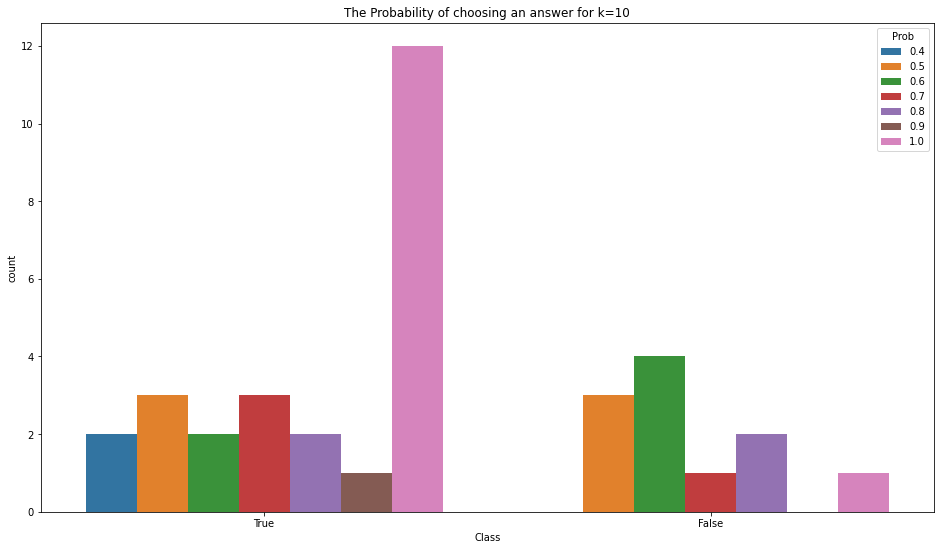

In [ ]:
K=10
prob_true_1, prob_false_1 = det_prob(x_test,y_test,x_train,y_train,K)
det_plot(prob_true_1, prob_false_1, K)

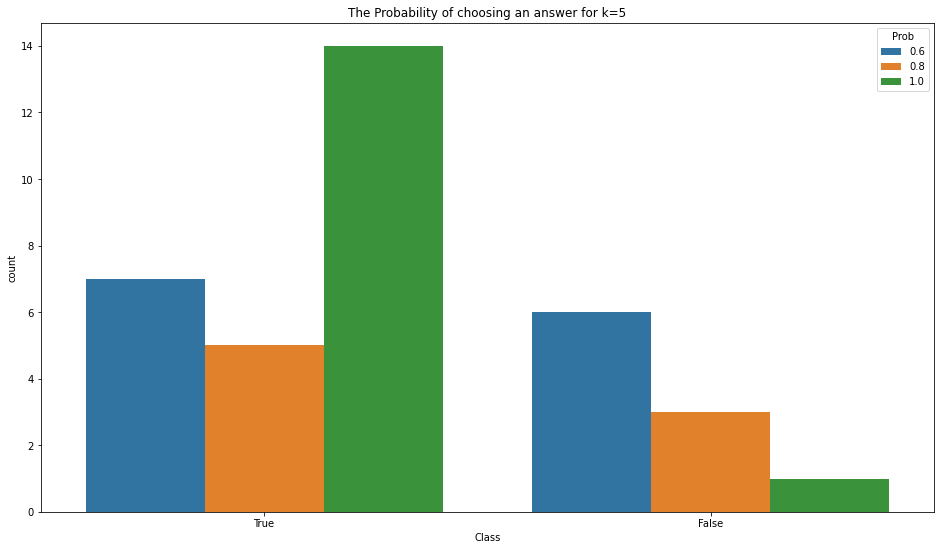

In [ ]:
K=5
prob_true_1, prob_false_1 = det_prob(x_test,y_test,x_train,y_train,K)
det_plot(prob_true_1, prob_false_1, K)

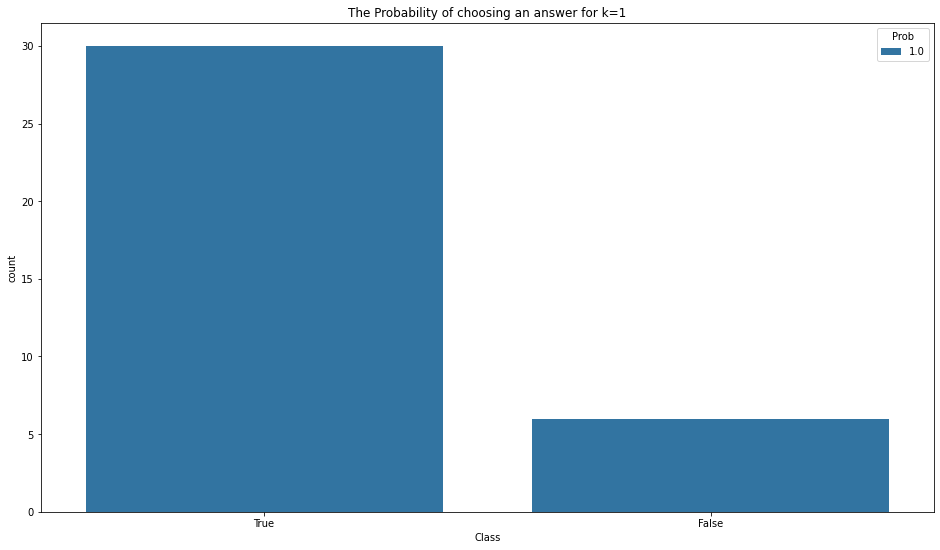

In [ ]:
K=1
prob_true_1, prob_false_1 = det_prob(x_test,y_test,x_train,y_train,K)
det_plot(prob_true_1, prob_false_1, K)

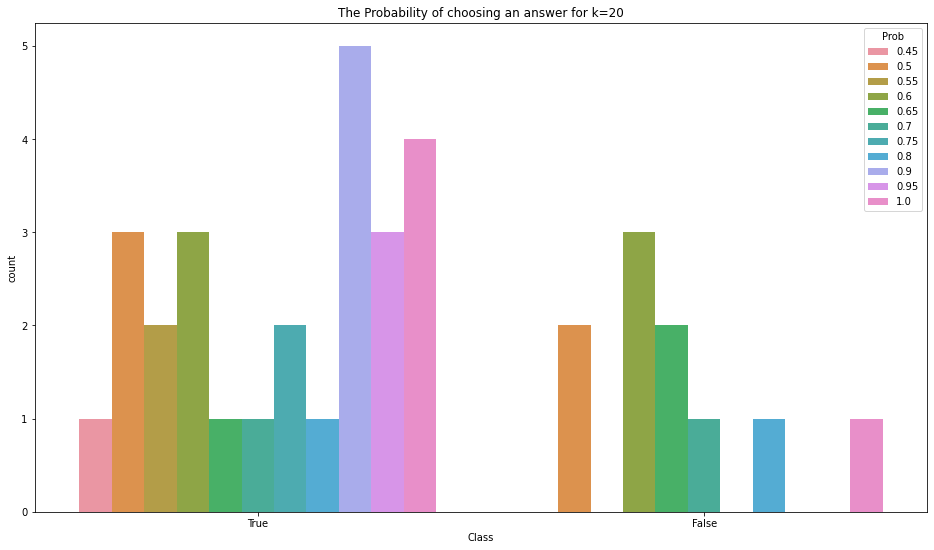

In [ ]:
K=20
prob_true_1, prob_false_1 = det_prob(x_test,y_test,x_train,y_train,K)
det_plot(prob_true_1, prob_false_1, K)

## Metric Based Learning

### Part 2) Mapped Data Plot

In [ ]:
def scat_plot(X,Y,k):
    x0 = X_reduced[np.where(Y==0)[0]]
    x1 = X_reduced[np.where(Y==1)[0]]
    x2 = X_reduced[np.where(Y==2)[0]]
    plt.figure(figsize=(5,10))
    plt.scatter(x0[:,0],x0[:,1], color='r', label='0')
    plt.scatter(x1[:,0],x1[:,1], color='g', label='1')
    plt.scatter(x2[:,0],x2[:,1], color='b', label='2')
    plt.xlabel('First Dim')
    plt.ylabel('Second Dim')
    if k==0:
        plt.title('Original')
    else:
        plt.title(f'Transformed ({k}NN)')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
from metric_learn import LFDA, LMNN

In [ ]:
lfda = LFDA(n_components=2, k=1)
lfda.fit(X,Y)
X_new_1 = lfda.fit_transform(X,Y)
lfda = LFDA(n_components=2, k=5)
lfda.fit(X,Y)
X_new_2 = lfda.fit_transform(X,Y)
lfda = LFDA(n_components=2, k=15)
lfda.fit(X,Y)
X_new_3 = lfda.fit_transform(X,Y)

/usr/local/lib/python3.8/dist-packages/metric_learn/lfda.py:109: UserWarning: Chosen k (15) too large, using 12 instead.
  warnings.warn('Chosen k (%d) too large, using %d instead.'
/usr/local/lib/python3.8/dist-packages/metric_learn/lfda.py:109: UserWarning: Chosen k (15) too large, using 12 instead.
  warnings.warn('Chosen k (%d) too large, using %d instead.'


In [ ]:
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.fit_transform(X,Y)

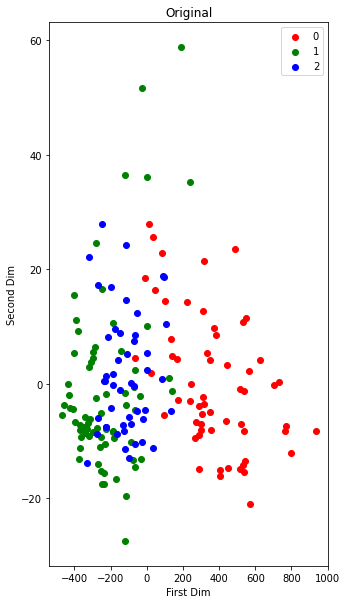

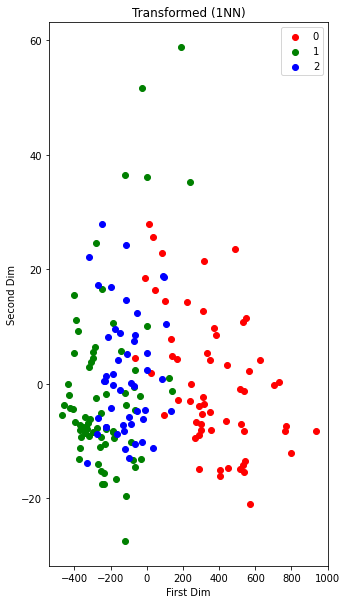

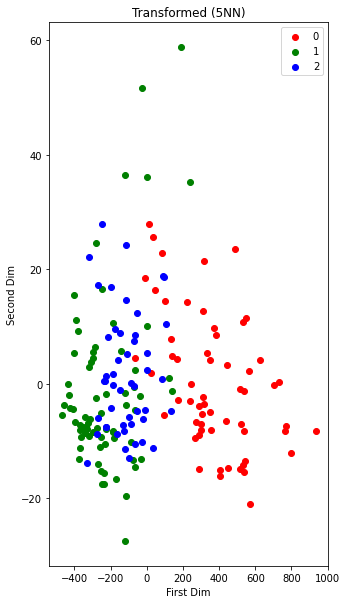

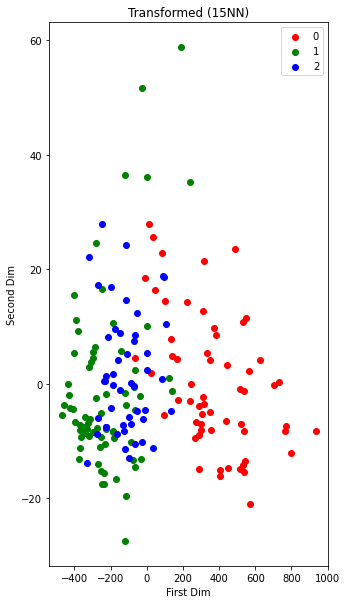

In [ ]:
scat_plot(X_reduced,Y,0)
scat_plot(X_new_1,Y,1)
scat_plot(X_new_2,Y,5)
scat_plot(X_new_3,Y,15)

In [ ]:
lmnn = LMNN(n_components=2, k=1)
lmnn.fit(X,Y)
X_new_1 = lmnn.fit_transform(X,Y)
lmnn = LMNN(n_components=2, k=5)
lmnn.fit(X,Y)
X_new_2 = lmnn.fit_transform(X,Y)
lmnn = LMNN(n_components=2, k=15)
lmnn.fit(X,Y)
X_new_3 = lmnn.fit_transform(X,Y)

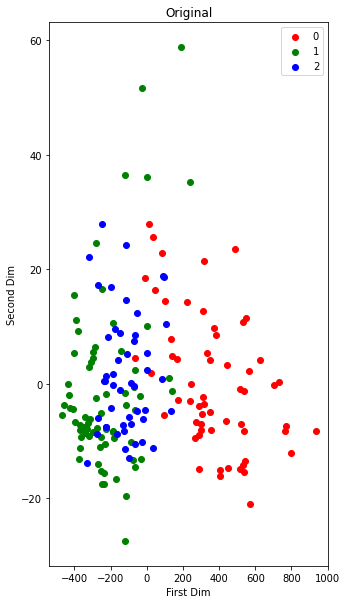

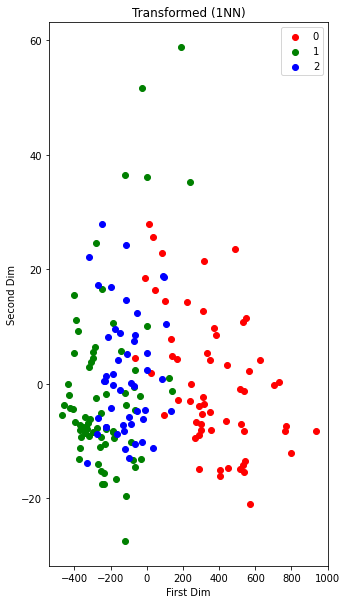

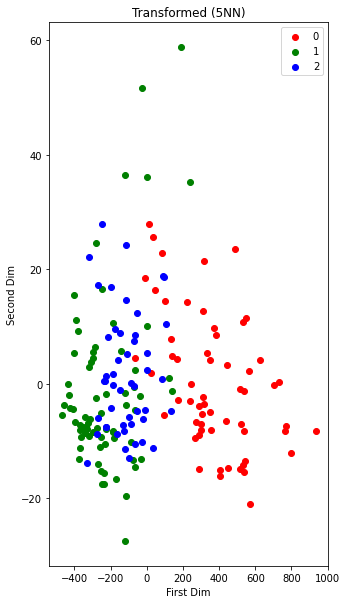

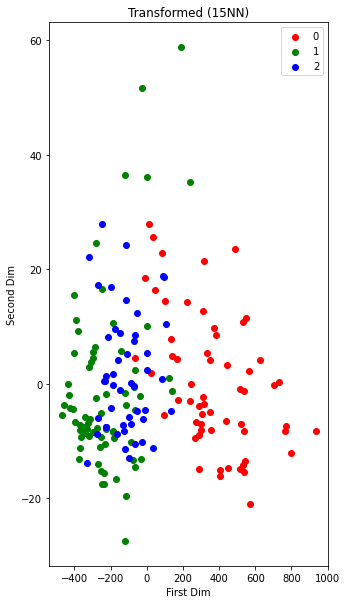

In [ ]:
scat_plot(X_reduced,Y,0)
scat_plot(X_new_1,Y,1)
scat_plot(X_new_2,Y,5)
scat_plot(X_new_3,Y,15)

### Part 3) KNN on best mapped data

In [ ]:
xtr, xts, ytr, yts = train_test_split(X_new_3, Y, test_size=0.2, random_state=1234)
yhat = KNN_Model(xts, xtr, ytr, 15)
acc = np.round(accuracy(yts,yhat),2) * 100
cm = confusion_matrix(yts,yhat)

In [ ]:
print("LMMN K=15")
print(f"Accuracy={acc}%")
print("** Confusion Matrix **")
print(cm)

LMMN K=15
Accuracy=97.0%
** Confusion Matrix **
[[ 9  1  0]
 [ 0 17  0]
 [ 0  0  9]]


### Part 4) Corr Plot

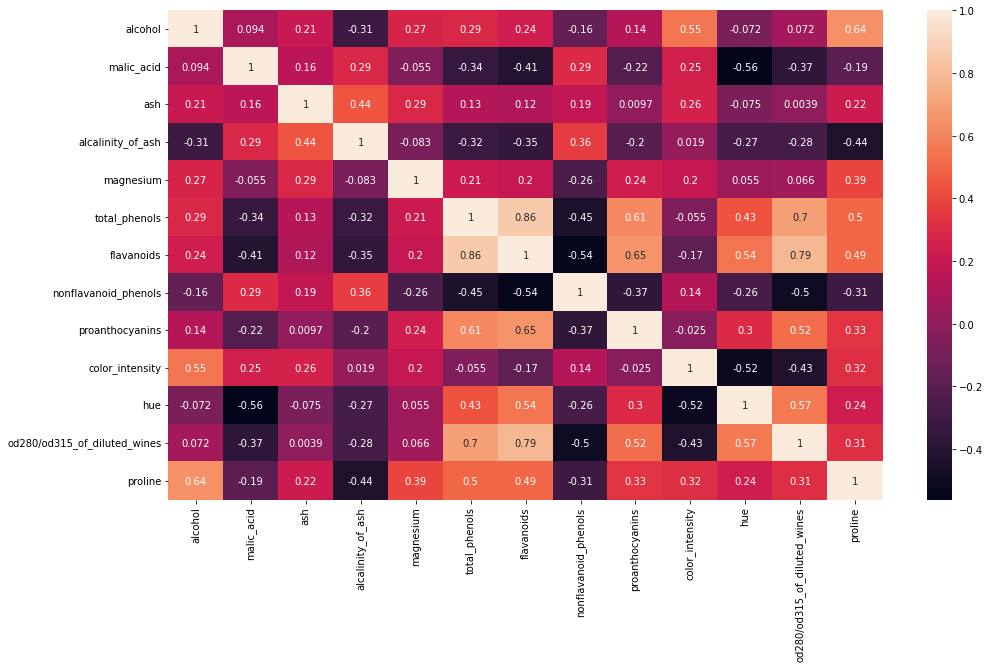

In [ ]:
features = data.feature_names
data_val = data.data
dic = {}
for i in range(13):
    dic[features[i]] = data_val[:,i]
df = pd.DataFrame(dic)
cor = df.corr()
plt.figure(figsize=(16,9))
sns.heatmap(cor,annot=True)

In [ ]:
lfda = LFDA(n_components=2, k=15)
lfda.fit(X,Y)
X_lfda = lfda.fit_transform(X,Y)
lmnn = LMNN(n_components=2, k=15)
lmnn.fit(X,Y)
X_lmnn = lmnn.fit_transform(X,Y)

/usr/local/lib/python3.8/dist-packages/metric_learn/lfda.py:109: UserWarning: Chosen k (15) too large, using 12 instead.
  warnings.warn('Chosen k (%d) too large, using %d instead.'
/usr/local/lib/python3.8/dist-packages/metric_learn/lfda.py:109: UserWarning: Chosen k (15) too large, using 12 instead.
  warnings.warn('Chosen k (%d) too large, using %d instead.'


Text(0.5, 1.0, 'LMNN')

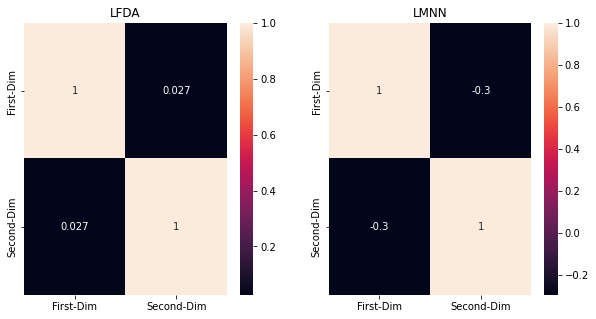

In [ ]:
dict_lfda = {'First-Dim':X_lfda[:,0],'Second-Dim':X_lfda[:,1]}
dict_lmnn = {'First-Dim':X_lmnn[:,0],'Second-Dim':X_lmnn[:,1]}
df_lfda = pd.DataFrame(dict_lfda)
df_lmnn = pd.DataFrame(dict_lmnn)
corr_lfda = df_lfda.corr()
corr_lmnn = df_lmnn.corr()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(corr_lfda,annot=True)
plt.title("LFDA")
plt.subplot(1,2,2)
sns.heatmap(corr_lmnn,annot=True)
plt.title("LMNN")